In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import sys
sys.path.append("../")
from utils import *
sys.path.append("../Google_HDRplus/")
from merge_utils import merge
sys.path.append("../flow_test/")
from pwc_on_raw import warped_raw
import time
import numpy as np

In [2]:
class WarpLayer(nn.Module):
    
    def __init__(self):
        super(WarpLayer, self).__init__()
        
    def warp(self, x, flo):
        """
        warp an image/tensor (im2) back to im1, according to the optical flow
        x: [B, C, H, W] (im2)
        flo: [B, 2, H, W] flow
        """
        B, C, H, W = x.size()
        # mesh grid 
        xx = torch.arange(0, W).view(1,-1).repeat(H,1)
        yy = torch.arange(0, H).view(-1,1).repeat(1,W)
        xx = xx.view(1,1,H,W).repeat(B,1,1,1)
        yy = yy.view(1,1,H,W).repeat(B,1,1,1)
        grid = torch.cat((xx,yy),1).float()

        if x.is_cuda:
            grid = grid.cuda()
        vgrid = Variable(grid) + flo

        # scale grid to [-1,1] 
        vgrid[:,0,:,:] = 2.0*vgrid[:,0,:,:].clone() / max(W-1,1)-1.0
        vgrid[:,1,:,:] = 2.0*vgrid[:,1,:,:].clone() / max(H-1,1)-1.0

        vgrid = vgrid.permute(0,2,3,1)        
        output = nn.functional.grid_sample(x, vgrid)
        mask = torch.autograd.Variable(torch.ones(x.size())).cuda()
        mask = nn.functional.grid_sample(mask, vgrid)

        # if W==128:
            # np.save('mask.npy', mask.cpu().data.numpy())
            # np.save('warp.npy', output.cpu().data.numpy())
        
        mask[mask<0.9999] = 0
        mask[mask>0] = 1
        
        return output*mask
    
    def forward(self, x):
        raw_stack = x[:, :4] #RGGB
        flow = x[:, 4:]
        
        x = self.warp(raw_stack, flow) 
        
        return x

In [3]:
model = WarpLayer().cuda()

In [4]:
print_model_params(model)

#total params: 0 | #trainable params: 0


In [5]:
bk_lvl = 50
print("black level of the sensor: ", bk_lvl)

black level of the sensor:  50


In [6]:
rIm=read_raw("../static_videos/lowlight3_frame16_bunny_3.raw", frame =16)
rIm = rIm[:, :2048, :3584]

In [7]:
ref_idx = 0
ref = rIm[ref_idx]

In [8]:
idx = 15
flow, warped_alt_gt = warped_raw(ref, rIm[idx], display = False)
alt = rIm[idx]
alt_stack = raw_to_stack(alt)
alt_t = torch.from_numpy(alt_stack.copy().transpose(2, 0, 1)).float()
flow_t = torch.from_numpy(flow.copy().transpose(2, 0, 1))
inputs = torch.cat([alt_t, flow_t], dim = 0).unsqueeze(0)
inputs.size()

torch.Size([1, 6, 1024, 1792])

In [9]:
outputs = model(inputs.cuda())

/home/qian/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "


In [10]:
outputs.size()

torch.Size([1, 4, 1024, 1792])

In [11]:
warped_alt_stack = outputs[0].detach().cpu().numpy().transpose(1, 2, 0)
warped_alt = stack_to_raw(warped_alt_stack)
warped_alt = warped_alt.astype(ref.dtype)

In [12]:
print_stat("warped_alt", warped_alt)

warped_alt  shape:  (2048, 3584) dtype: int16
warped_alt stat: max: 79, min: 0, mean: 55.12662805829729, std: 7.602276975135676


In [13]:
print_stat("warped_alt_gt", warped_alt_gt)

warped_alt_gt  shape:  (2048, 3584) dtype: int16
warped_alt_gt stat: max: 80, min: 0, mean: 55.673718316214426, std: 7.328570360191901


In [14]:
np.mean((warped_alt_gt - warped_alt)**2)

3.984076908656529

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

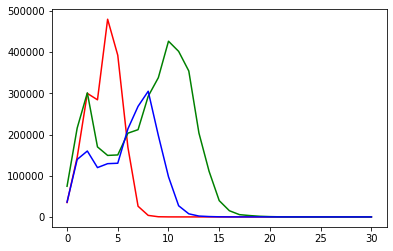

In [22]:
gt = warped_alt_gt - bk_lvl
gt = np.clip(gt, 0, 1023)
plot_histogram(gt, 5)

In [16]:
gt = demosaic(gt)
rgb_gt = adjustColor(gt,rc = 1, bc = 1, gc = 0.7, gain=1.3, gamma = 1.25, contrast=1.5)

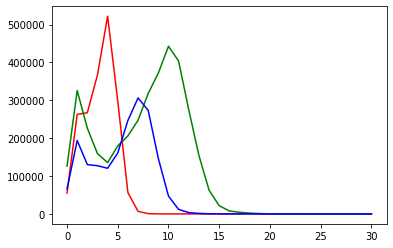

In [23]:
pred = warped_alt - bk_lvl
pred = np.clip(pred, 0, 1023)
plot_histogram(pred, 5)

In [17]:
pred = demosaic(pred)
rgb_pred = adjustColor(pred,rc = 1, bc = 1, gc = 0.7, gain=1.3, gamma = 1.25, contrast=1.5)

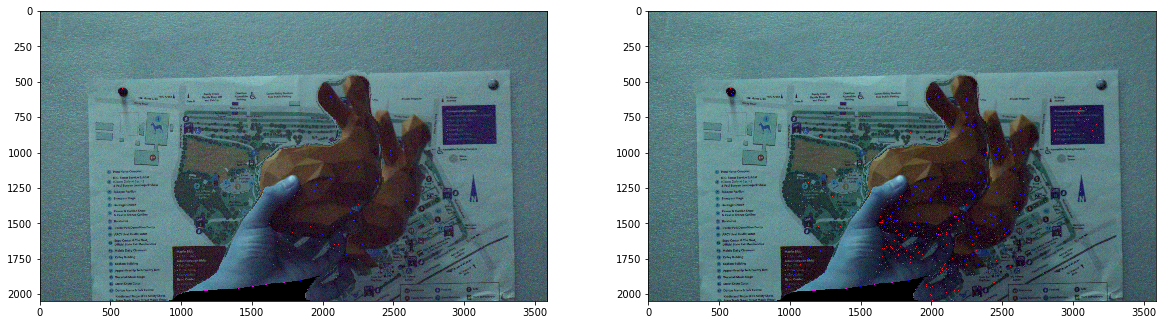

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(20, 16))
ax[0].imshow(rgb_gt)
ax[1].imshow(rgb_pred)
plt.show()